<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/35_4_GAN_MNIST_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание 1. На 3 балла:**

1. Ваша задача, используя датасет MNIST (из набора датасетов Tensorflow) научить GAN генерировать цифры.

2. Добейтесь хорошего качества генерации.

**Задание 2. На 4 балла:**

1. Ваша задача, используя датасет MNIST Fashion (из набора датасетов Tensorflow) научить GAN генерировать образцы одежды, соответственно.

2. Добейтесь хорошего качества генерации.

In [1]:
from random import randint
from keras.datasets import fashion_mnist

from PIL import Image
import imageio
import cv2
from keras.preprocessing.image import img_to_array

import numpy as np
import os
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# обучающие данные
print(train_images.shape)
print(len(train_images))
print(train_images.dtype)
print(train_images)

(60000, 28, 28)
60000
uint8
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [4]:
# тестовые данные
print(test_images.shape)
print(len(test_labels))
print(test_labels.dtype)
print(test_labels)

(10000, 28, 28)
10000
uint8
[9 2 1 ... 8 1 5]


In [5]:
# наименования меток
class_names = ['Футболка', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

Номер метки изображения: 0
Наименование метки изображения: Футболка 



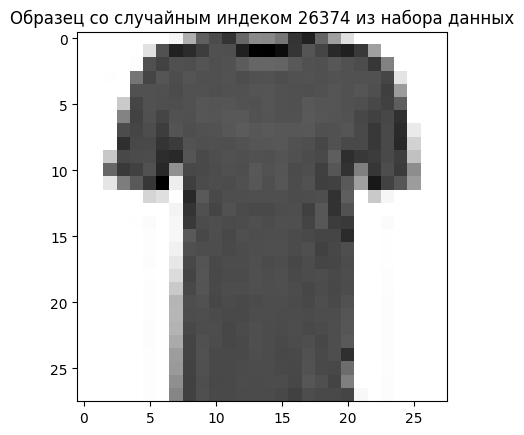

In [6]:
random_number = randint(0, len(train_labels))

digit = train_images[random_number]
fig, ax = plt.subplots(1,1)
print(f'Номер метки изображения: {train_labels[random_number]}')
print(f'Наименование метки изображения: {class_names[train_labels[random_number]]}', '\n')
ax.set_title(f'Образец со случайным индеком {random_number} из набора данных')
ax.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [47]:
# константы
SIZE = 28                  # линейный размер изображений (одно измерение)
INPUT_IMG = (SIZE, SIZE, 1) # размер входного изображений
BATCH_SIZE = 32             # размер пакета для обучения
LATENT_DIM = 1000           # размерность латентного пространства
print(INPUT_IMG)

(28, 28, 1)


In [48]:
train_images = train_images.astype(float)
print(train_images.dtype)

train_images = (train_images - 127.5) / 127.5
X_train = np.array(train_images)

print(X_train.shape)

float64
(60000, 28, 28)


In [49]:
dataset=tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [50]:
def Generator():
    model = Sequential()
    model.add(Dense(SIZE*SIZE*1, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(Reshape(INPUT_IMG))
    # downsampling (понижающая дискретизация)
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*4, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(SIZE*4,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(tf.keras.layers.LeakyReLU())
    #upsampling (повышающая дискретизация)
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*4, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*4, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*2, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(SIZE*2, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(SIZE, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(SIZE, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1,4,strides = 1, padding = 'same',activation = 'tanh'))

    return model

In [51]:
generator = Generator()
generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 784)                 │         784,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 28)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 14, 14, 28)          │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 14, 14, 28)          │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 14, 14, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 14, 14, 56)          │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 7, 7, 56)            │          50,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 7, 7, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 7, 7, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 7, 7, 112)           │         100,352 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 4, 4, 112)           │         200,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 4, 4, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 4, 4, 112)           │         200,704 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 8, 8, 112)           │         200,704 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 8, 8, 112)           │             448 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 8, 8, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 8, 8, 56)            │         100,352 │
│ (Conv2DTranspose)                    │                             │              

 Total params: 1,764,449 (6.73 MB)

 Trainable params: 1,763,889 (6.73 MB)

 Non-trainable params: 560 (2.19 KB)

In [52]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(INPUT_IMG))
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*2,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(SIZE*4,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [53]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 14, 14, 28)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 14, 14, 28)          │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 14, 14, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 7, 7, 28)            │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 7, 7, 28)            │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 7, 7, 28)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 4, 4, 56)            │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 4, 4, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 4, 4, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 2, 2, 56)            │          50,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 2, 2, 56)            │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 2, 2, 56)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 1, 1, 112)           │         100,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_26 (LeakyReLU)           │ (None, 1, 1, 112)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             113 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,393 (739.82 KB)

 Trainable params: 189,057 (738.50 KB)

 Non-trainable params: 336 (1.31 KB)

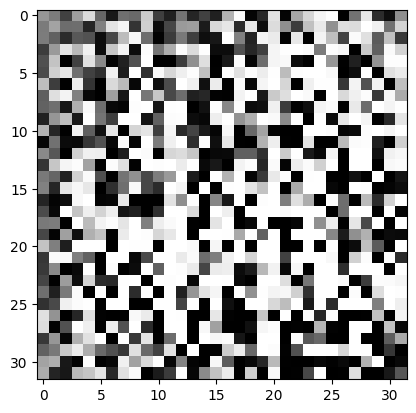

In [54]:
noise = np.random.normal(-1,1,(1,LATENT_DIM))
img = generator(noise)
plt.imshow(img[0,:,:,0], cmap=plt.cm.binary)
plt.show()

In [55]:
optimizer_G = tf.keras.optimizers.RMSprop(learning_rate=.0001)
optimizer_D = tf.keras.optimizers.RMSprop(learning_rate=.0001)

# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [56]:
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_steps(images):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

In [57]:
import time
def train(epochs, dataset):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [58]:
G, D = train(10, dataset)


Эпоха : 1
 Время:23.0
Generator Loss: 14.469659805297852 Discriminator Loss: 6.258008511395019e-07

Эпоха : 2
 Время:19.0
Generator Loss: 15.236417770385742 Discriminator Loss: 3.011357989635144e-07

Эпоха : 3
 Время:19.0
Generator Loss: 15.752250671386719 Discriminator Loss: 2.0368464959119592e-07

Эпоха : 4
 Время:19.0
Generator Loss: 16.09679412841797 Discriminator Loss: 1.6176690564861929e-07

Эпоха : 5
 Время:19.0
Generator Loss: 16.42007827758789 Discriminator Loss: 1.335138506419753e-07

Эпоха : 6
 Время:19.0
Generator Loss: 16.593955993652344 Discriminator Loss: 1.21726657198451e-07

Эпоха : 7
 Время:19.0
Generator Loss: 16.775917053222656 Discriminator Loss: 1.1138462241433444e-07

Эпоха : 8
 Время:19.0
Generator Loss: 16.93570327758789 Discriminator Loss: 1.0373476300173934e-07

Эпоха : 9
 Время:20.0
Generator Loss: 17.112794876098633 Discriminator Loss: 9.655854427137456e-08

Эпоха : 10
 Время:19.0
Generator Loss: 17.213685989379883 Discriminator Loss: 9.300756431684931e-08

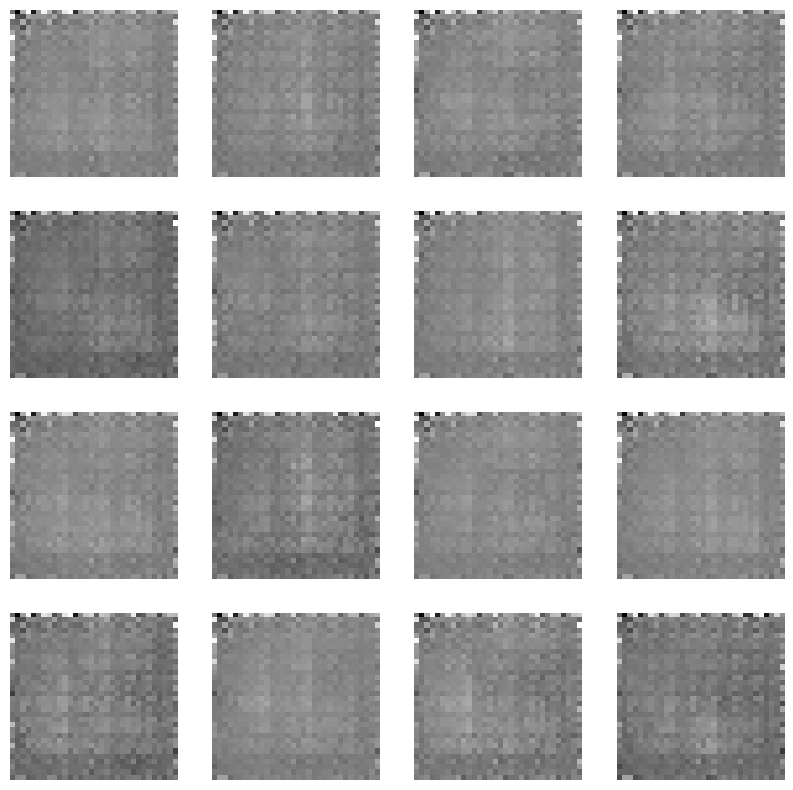

In [60]:
def plot_generated_images(square = 4):
    plt.figure(figsize = (10,10))
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,LATENT_DIM))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap=plt.cm.binary)
        plt.axis('off')
        plt.grid()

plot_generated_images(4)

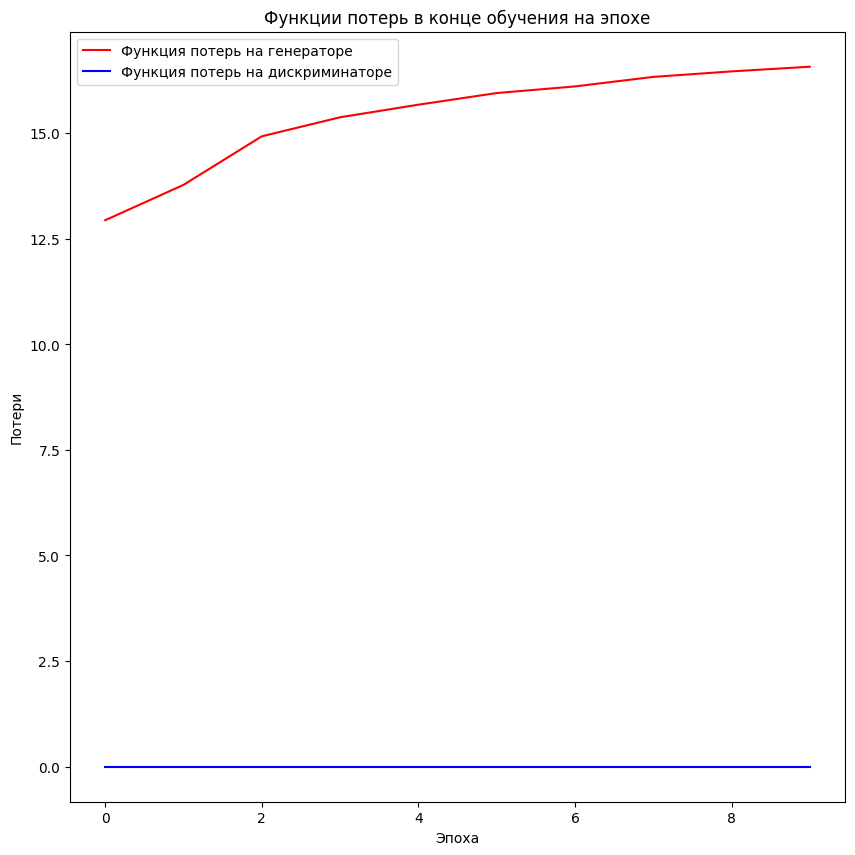

In [24]:
def loss_plot(G, D):
    plt.figure(figsize=(10,10))
    plt.plot(G,color='red',label='Функция потерь на генераторе')
    plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Функции потерь в конце обучения на эпохе')
    plt.show()

loss_plot(G, D)

In [25]:
G, D = train(100, dataset)


Эпоха : 1
 Время:25.0
Generator Loss: 16.66404151916504 Discriminator Loss: 6.599540114393676e-08

Эпоха : 2
 Время:25.0
Generator Loss: 16.809322357177734 Discriminator Loss: 5.708082895239386e-08

Эпоха : 3
 Время:26.0
Generator Loss: 16.9078311920166 Discriminator Loss: 5.147047232867408e-08

Эпоха : 4
 Время:24.0
Generator Loss: 17.02874183654785 Discriminator Loss: 4.555589683263861e-08

Эпоха : 5
 Время:24.0
Generator Loss: 17.127235412597656 Discriminator Loss: 4.053200086673314e-08

Эпоха : 6
 Время:24.0
Generator Loss: 17.212127685546875 Discriminator Loss: 3.732467135364459e-08

Эпоха : 7
 Время:24.0
Generator Loss: 17.265789031982422 Discriminator Loss: 3.529072500896291e-08

Эпоха : 8
 Время:24.0
Generator Loss: 17.326990127563477 Discriminator Loss: 3.3323136250373864e-08

Эпоха : 9
 Время:24.0
Generator Loss: 17.401681900024414 Discriminator Loss: 3.065551013037293e-08

Эпоха : 10
 Время:25.0
Generator Loss: 17.488494873046875 Discriminator Loss: 2.8038758870252423e-08



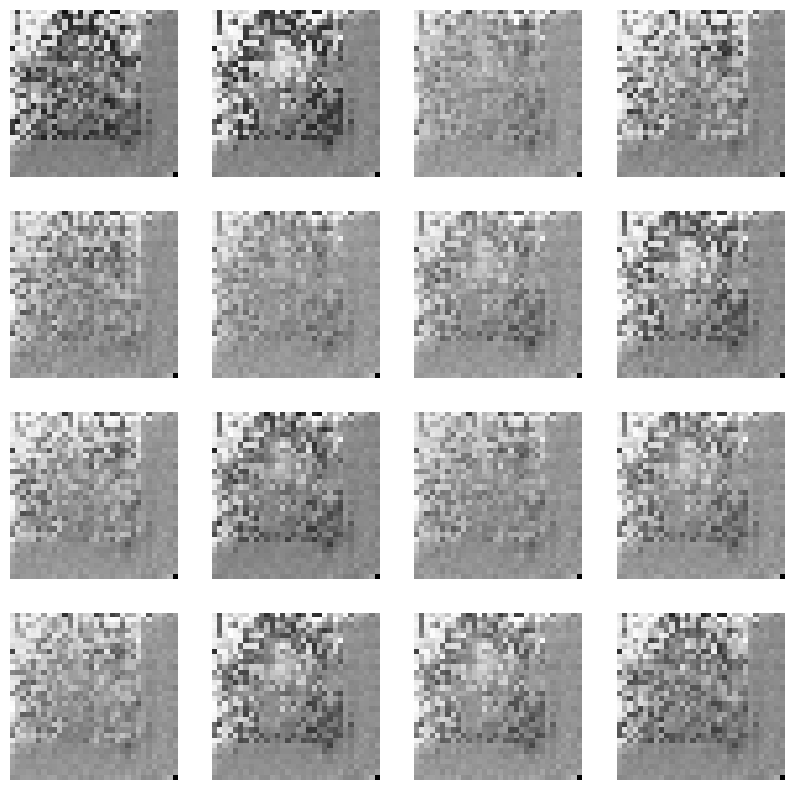

In [26]:
def plot_generated_images(square = 4):
    plt.figure(figsize = (10,10))
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,LATENT_DIM))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap=plt.cm.binary)
        plt.axis('off')
        plt.grid()

plot_generated_images(4)

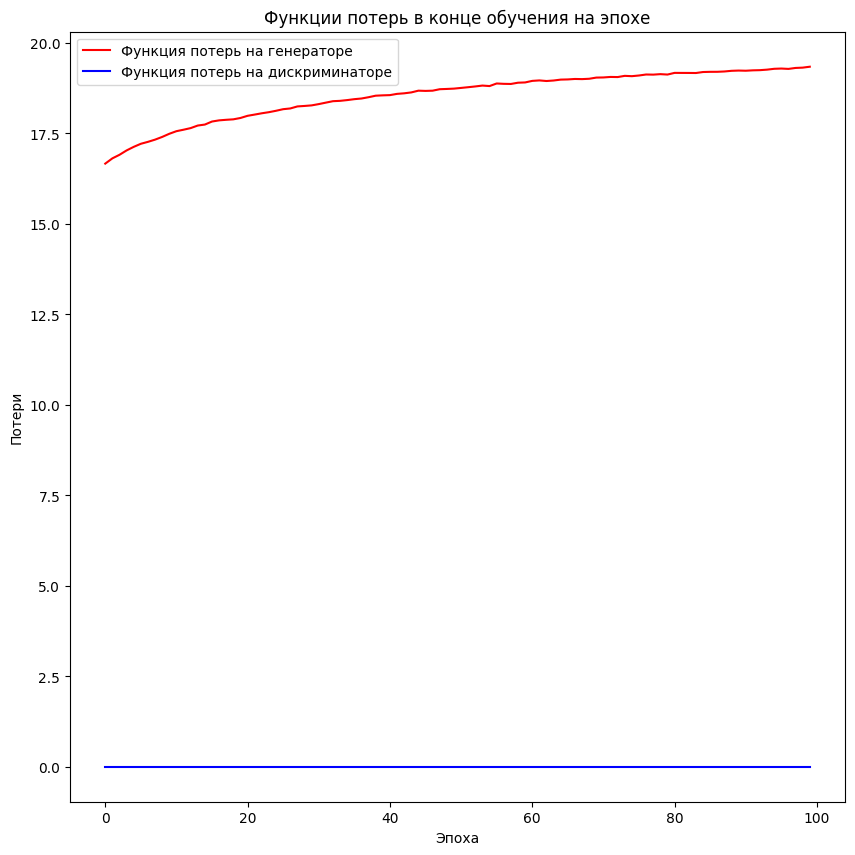

In [27]:
def loss_plot(G, D):
    plt.figure(figsize=(10,10))
    plt.plot(G,color='red',label='Функция потерь на генераторе')
    plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Функции потерь в конце обучения на эпохе')
    plt.show()

loss_plot(G, D)